# Face Classification

### Library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


### hyperparameter setting

In [ ]:
learning_rate = 1e-3
training_epochs = 300
display_step = 10
batch_size = 32    

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2)

### Load data & Pre-process data

In [ ]:
trans = transforms.Compose([transforms.Resize(32), transforms.ToTensor()]) 
dataset = torchvision.datasets.ImageFolder(root = './faceset', transform = trans) 

In [ ]:
dataset.__getitem__(0)

(tensor([[[0.1373, 0.1294, 0.1333,  ..., 0.1255, 0.1294, 0.1294],
          [0.1333, 0.1294, 0.1294,  ..., 0.1176, 0.1294, 0.1294],
          [0.1333, 0.1333, 0.1373,  ..., 0.1098, 0.1255, 0.1373],
          ...,
          [0.5765, 0.5804, 0.6157,  ..., 0.5059, 0.5255, 0.5725],
          [0.5882, 0.6275, 0.6275,  ..., 0.5137, 0.5176, 0.5529],
          [0.6196, 0.6510, 0.5137,  ..., 0.5255, 0.5176, 0.5529]],
 
         [[0.1098, 0.1137, 0.1137,  ..., 0.0824, 0.0863, 0.0824],
          [0.1098, 0.1059, 0.1059,  ..., 0.0824, 0.0863, 0.0863],
          [0.1098, 0.1059, 0.1059,  ..., 0.0745, 0.0863, 0.0941],
          ...,
          [0.5529, 0.5451, 0.5804,  ..., 0.3725, 0.4157, 0.4706],
          [0.5686, 0.5922, 0.5882,  ..., 0.3765, 0.3961, 0.4471],
          [0.6000, 0.6157, 0.4706,  ..., 0.3843, 0.3961, 0.4471]],
 
         [[0.1137, 0.1098, 0.1098,  ..., 0.0980, 0.1098, 0.1176],
          [0.1098, 0.1059, 0.1098,  ..., 0.0902, 0.1059, 0.1137],
          [0.1137, 0.1137, 0.1176,  ...,

In [ ]:
len(dataset)

600

In [ ]:
classes = dataset.classes
classes

['front', 'nonfront', 'profile']

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [480, 120])

In [ ]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

data shape:  torch.Size([32, 3, 32, 32])
label:  tensor([1, 0, 1, 2, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 1,
        2, 1, 2, 1, 0, 1, 0, 0])


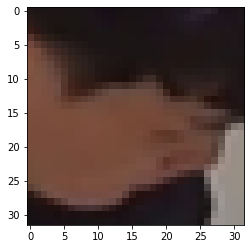

In [ ]:
# check the data

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape: ', example_data.shape)
print('label: ', example_target)


check_image = example_data[0]
check_image = np.transpose(check_image, (1,2,0))

plt.figure()
plt.imshow(check_image)
plt.show()

### Model & Optimization and Loss function

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            
            # input_size = 32 X 32 X 3
            nn.Conv2d(3, 64, 2), 
            activation,
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128,2),  
            activation,
            nn.BatchNorm2d(128),
            max_pool,  
            nn.Dropout2d(0.4),
            
            
            nn.Conv2d(128,128,2), 
            activation,
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3), 
            activation,
            nn.BatchNorm2d(256),
            max_pool,  
            nn.Dropout2d(0.4),
            
            
            nn.Conv2d(256,512,2),  
            activation,
            nn.BatchNorm2d(512),
            nn.Conv2d(512,512,2), 
            activation,
            nn.BatchNorm2d(512),
            max_pool,  
            nn.Dropout2d(0.4)
            
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 256),
            activation,
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) 
        flatten = extracted_feature.view(batch_size, -1)
        result = self.classifier(flatten)
        return result

In [ ]:
model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Train & Test

In [ ]:
loss_array = []
    
#train the model
for i in range(training_epochs):
    for idx, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i, loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 0.5303168892860413
10 epoch loss: 0.005867034196853638
20 epoch loss: 0.07923996448516846
30 epoch loss: 0.11438813805580139
40 epoch loss: 0.03837389871478081
50 epoch loss: 0.010124062187969685
60 epoch loss: 0.0005152191151864827
70 epoch loss: 5.5757100199116394e-05
80 epoch loss: 0.08914168179035187
90 epoch loss: 0.0005843483377248049
100 epoch loss: 0.00033940092544071376
110 epoch loss: 0.0003481441526673734
120 epoch loss: 1.1946189260925166e-05
130 epoch loss: 4.0391696529695764e-05
140 epoch loss: 0.025203688070178032
150 epoch loss: 3.346943049109541e-05
160 epoch loss: 1.3198035048844758e-05
170 epoch loss: 3.889134859491605e-06
180 epoch loss: 2.995045178977307e-06
190 epoch loss: 1.9213208361179568e-05
200 epoch loss: 0.024479057639837265
210 epoch loss: 3.473913238849491e-05
220 epoch loss: 0.02627008780837059
230 epoch loss: 0.0005674283020198345
240 epoch loss: 0.0008708901004865766
250 epoch loss: 9.298548684455454e-05
260 epoch loss: 6.239608410396613e

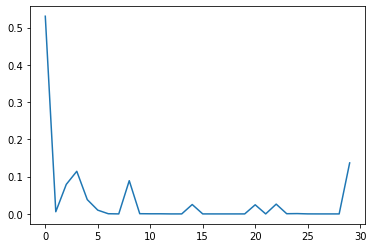

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Test accuracy: {}".format(correct/total))

Valid accuracy: 0.9166666865348816
